In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

import torch.optim as optim

In [2]:
def check_hemi(A):
    A_chop = A[1:,:]
    avg = A_chop + A_chop.flip(dims=[0])
    real_norm = avg.real.norm()
    imag_norm = avg.imag.norm()
    imag_ratio = imag_norm / math.sqrt(real_norm**2 + imag_norm**2)
    print(imag_ratio)

def keep_hemi(A):
    A[1:,:] = (A[1:,:] + A[1:,:].flip(dims=[0]).conj()) / 2

# check how to compute the terms
def get_circular(v):
    n = v.shape[0]
    ret = torch.ones(n, n, dtype=v.dtype).to(v.device)
    for i in range(n):
        for j in range(n):
            ret[i, j] = v[(i - j + n) % n]

    return ret

def circular_conv(*args):
    final = args[0]
    for v in args[1:]:
        final = get_circular(v) @ final
    return final

def complex_dot(v1, v2):
    return (v1.conj() * v2).sum()

def compute_approx_grad(A, B, C):
    AA = A.conj().t() @ A
    BB = B.conj().t() @ B
    CC = C.conj().t() @ C

    K = A.shape[1]
    device = A.device
    
    dA = B.conj() * C - 2 * A @ (BB * CC)
    dB = A.conj() * C - 2 * B @ (AA * CC) 
    dC = (A*B) - 2 * C @ (AA * BB)

    return dA, dB, dC


def compute_grad(A, B, C):
    AA = A.conj().t() @ A
    BB = B.conj().t() @ B
    CC = C.conj().t() @ C

    d = A.shape[0]
    K = A.shape[1]
    device = A.device
    
    # diagonal elements
    anormsqr = AA.diag()
    bnormsqr = BB.diag() 

    # First conv results
    Aconvs = torch.zeros(d, K, K, dtype=torch.cfloat).to(device)
    Bconvs = torch.zeros(d, K, K, dtype=torch.cfloat).to(device)
    for jj in range(K):
        curr_Aconv = circular_conv(A[:,jj], A[:,jj])
        curr_Bconv = circular_conv(B[:,jj], B[:,jj])
        for j in range(K):
            Aconvs[:,j,jj] = circular_conv(A[:,j], curr_Aconv)
            Bconvs[:,j,jj] = circular_conv(B[:,j], curr_Bconv)
        
    # construct convolutional results
    Aconvs_term = torch.einsum("abc,cb->ab", Aconvs, CC)
    Bconvs_term = torch.einsum("abc,cb->ab", Bconvs, CC)
            
    Aconvs_termC = torch.einsum("abc,ab->cb", Aconvs.conj(), A) 
    Bconvs_termC = torch.einsum("abc,ab->cb", Bconvs.conj(), B) 
    
    dA = B.conj() * C - A @ (CC @ bnormsqr).diag() - 2 * A @ (BB * CC) - Aconvs_term
    dB = A.conj() * C - B @ (CC @ anormsqr).diag() - 2 * B @ (AA * CC) - Bconvs_term
    dC = (A*B) - C @ (torch.outer(anormsqr, bnormsqr) + torch.outer(bnormsqr, anormsqr) + 4 * AA * BB + Aconvs_termC + Bconvs_termC) / 2

    return dA, dB, dC

In [30]:
def find_optimal_delta(A, B, C, r=0.01, eps=0.001, nIter=100):
    # Search local dA, dB, dC that lead to maximal deviation. 

    def get_perturb_like(M, r):
        res = torch.randn_like(M)
        return res / res.norm() * r

    def add_perturb(M, eps, r):
        res = torch.randn_like(M) 
        dM = M + res / res.norm() * eps
        return dM / dM.norm() * r

    dA = get_perturb_like(A, r)
    dB = get_perturb_like(B, r)
    dC = get_perturb_like(C, r)

    for t in range(nIter):
        # Locally perturbation
        best_score = -10000.0
        best_perturb = []
        for k in range(100):
            dA_perturb = add_perturb(dA, eps, r)
            dB_perturb = add_perturb(dB, eps, r)
            dC_perturb = add_perturb(dC, eps, r)

            dA2, dB2, dC2 = compute_approx_grad(A + dA_perturb, B + dB_perturb, C + dC_perturb)
            # compute score
            score = (dA_perturb.conj() * dA2).sum() + (dB_perturb.conj() * dB2).sum() + (dC_perturb.conj() * dC2).sum() 
            if score.real.item() > best_score:
                best_score = score.real.item()
                best_perturb = [dA_perturb, dB_perturb, dC_perturb]

        # Then we update
        print(f"iter{t}: best_score = {best_score}")
        
        if best_score > 0:
            dA, dB, dC = best_perturb

    return dA, dB, dC

In [4]:
def perfect_memorization_init(d, use_cuda=False, remove_e0=True, noise=0.001):
    K = d * d
    A = torch.zeros(d, K, dtype=torch.cfloat)
    B = torch.zeros(d, K, dtype=torch.cfloat)
    C = torch.zeros(d, K, dtype=torch.cfloat)

    if use_cuda:
        A = A.cuda()
        B = B.cuda()
        C = C.cuda()

    device = A.device

    v = torch.ones(d, dtype=torch.cfloat).to(device)
    # unit 
    for i in range(d):
        v[i].real = math.cos(2 * math.pi * i / d)
        v[i].imag = math.sin(2 * math.pi * i / d)

    # construct 
    cnt = 0
    for i in range(d):
        for j in range(d):
            A[:,cnt] = v[:] ** i
            B[:,cnt] = v[:] ** j
            C[:,cnt] = v[:] ** ((i + j) % d)
            cnt += 1
            
    A = A / math.sqrt(d)
    B = B / math.sqrt(d)
    C = C / 2 / d

    if noise is not None:

        # adding some noise
        A = A + torch.randn(d, K, dtype=torch.cfloat).to(device) * noise
        B = B + torch.randn(d, K, dtype=torch.cfloat).to(device) * noise
        C = C + torch.randn(d, K, dtype=torch.cfloat).to(device) * noise

        keep_hemi(A)
        keep_hemi(B)
        keep_hemi(C)

    # Getting rid of e_0
    if remove_e0:
        A[0,:] = 0
        B[0,:] = 0
        C[0,:] = 0

    return A, B, C

In [6]:
d = 7
A, B, C = perfect_memorization_init(d, use_cuda=False, remove_e0=True, noise=None)

In [33]:
dA, dB, dC = find_optimal_delta(A, B, C, r=0.1, eps=0.1, nIter=10)

iter0: best_score = -0.014558250084519386
iter1: best_score = -0.014387845061719418
iter2: best_score = -0.013956966809928417
iter3: best_score = -0.014497761614620686
iter4: best_score = -0.01420658640563488
iter5: best_score = -0.014479801058769226
iter6: best_score = -0.014680080115795135
iter7: best_score = -0.014846810139715672
iter8: best_score = -0.014713747426867485
iter9: best_score = -0.014742255210876465


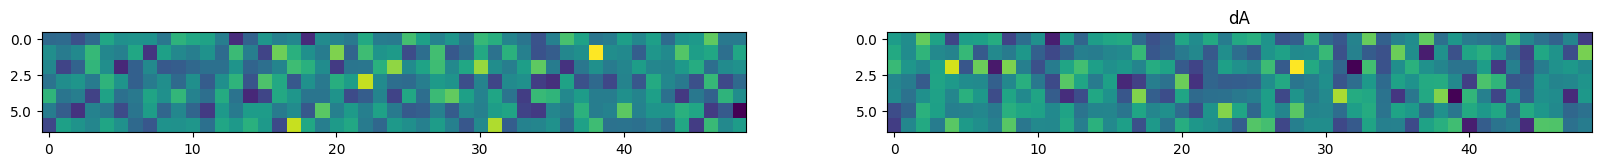

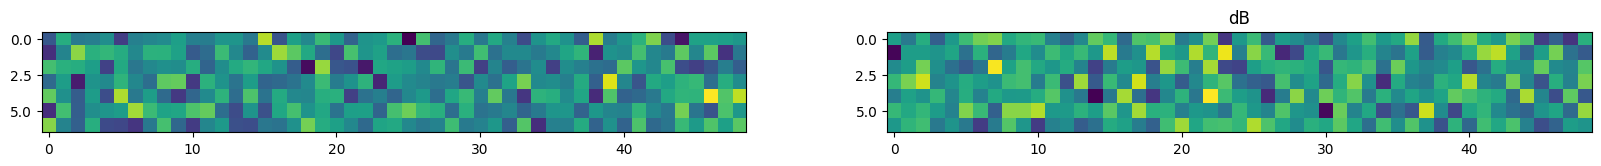

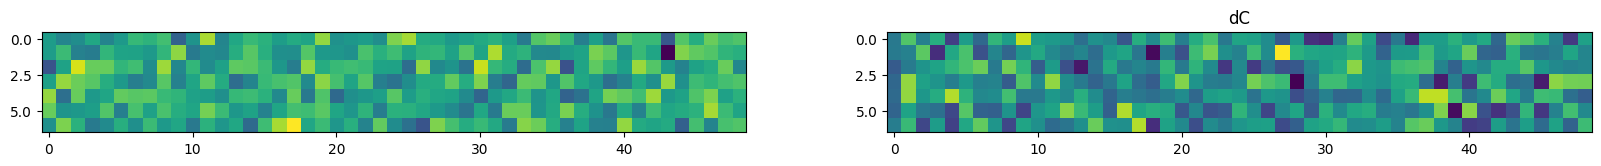

In [19]:
def plot_complex(M, title):
    plt.subplot(1, 2, 1)
    plt.imshow(M.real)
    plt.subplot(1, 2, 2)
    plt.imshow(M.imag)
    plt.title(title)
    plt.show()
    

plt.figure(figsize=(20, 30))
plot_complex(dA, "dA")
plt.figure(figsize=(20, 30))
plot_complex(dB, "dB")
plt.figure(figsize=(20, 30))
plot_complex(dC, "dC")

In [36]:
# Check 
K = A.shape[1]
device = A.device

Aconvs = torch.zeros(d, K, K, dtype=torch.cfloat).to(device)
Bconvs = torch.zeros(d, K, K, dtype=torch.cfloat).to(device)
for jj in range(K):
    curr_Aconv = circular_conv(A[:,jj], A[:,jj])
    curr_Bconv = circular_conv(B[:,jj], B[:,jj])
    for j in range(K):
        Aconvs[:,j,jj] = circular_conv(A[:,j], curr_Aconv)
        Bconvs[:,j,jj] = circular_conv(B[:,j], curr_Bconv)

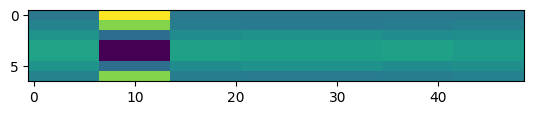

In [74]:
plt.imshow(Aconvs[:,:,7].real)

In [40]:
Aconvs[:,:,0].real

tensor([[ 1.6198,  1.6198,  1.6198,  1.6198,  1.6198,  1.6198,  1.6198, -0.2700,
         -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700,
         -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700,
         -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700,
         -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700,
         -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700, -0.2700,
         -0.2700],
        [ 1.6738,  1.6738,  1.6738,  1.6738,  1.6738,  1.6738,  1.6738, -0.2363,
         -0.2363, -0.2363, -0.2363, -0.2363, -0.2363, -0.2363, -0.2820, -0.2820,
         -0.2820, -0.2820, -0.2820, -0.2820, -0.2820, -0.3186, -0.3186, -0.3186,
         -0.3186, -0.3186, -0.3186, -0.3186, -0.3186, -0.3186, -0.3186, -0.3186,
         -0.3186, -0.3186, -0.3186, -0.2820, -0.2820, -0.2820, -0.2820, -0.2820,
         -0.2820, -0.2820, -0.2363, -0.2363, -0.2363, -0.2363, -0.2363, -0.2363,
         

In [52]:
Aconvs[:,:,10].real.sum(dim=1)

tensor([ 5.0068e-06,  1.7881e-06, -1.0580e-06, -4.2915e-06, -4.4107e-06,
        -1.2219e-06,  1.8477e-06])

In [80]:
(Aconvs[:,:,8] - Aconvs[:,:,7]).norm()

tensor(0.)